In [2]:
import torch
import os, sys

sys.path.append('../')

from model.generators.enlighten_gan_generator import GeneratorEnlightenGAN
from model.discriminators.enlighten_gan_global_discriminator import GlobalDiscriminatorEnlightenGAN
from model.discriminators.enlighten_gan_local_discriminator import LocalDiscriminatorEnlightenGAN
from model.model import Model
from model.attention_map import AttentionMapGray
from model.loses.gan_loss import GanLoss
from model.vgg import Vgg16
from model.loses.vgg_loss import VGGLoss
from utils import patches
# from utils import weights
from data_loader import ABDataset

from torch.utils.data import DataLoader

In [5]:
device = torch.device("cuda")
netG = GeneratorEnlightenGAN()
netG.to(device)
# netG = torch.nn.DataParallel(netG, device_ids=[0])

netD_global = GlobalDiscriminatorEnlightenGAN()
netD_global.to(device)
# netD_global = torch.nn.DataParallel(netD_global, device_ids=[0])

num_patches = 5
netD_local = LocalDiscriminatorEnlightenGAN(n=num_patches)
netD_local.to(device)
# netD_local = torch.nn.DataParallel(netD_local, device_ids=[0])

attention_map = AttentionMapGray()
criterion = GanLoss()
vgg_loss = VGGLoss()

netVgg = Vgg16()
netVgg.to(device)
model_dir = '../saved_models'
netVgg.load_state_dict(torch.load(os.path.join(model_dir, 'vgg16.weight')))
# netVgg = torch.nn.DataParallel(netVgg, device_ids=[0])

model = Model(netG, netD_global, netD_local, criterion, netVgg, vgg_loss)

niter = 100
niter_decay = 100
dataset_root = '/home/student/Documents/alena/thesis/enlighte-gan-dataset'

dataset = ABDataset(dataset_root, attention_map)
dataset = DataLoader(dataset, batch_size=5, num_workers=1)

In [6]:
for epoch in range(niter + niter_decay + 1):
    for i, data in enumerate(dataset):
        img_dark = data['dark'].to("cuda")
        img_normal = data['normal'].to("cuda")
        img_gray = data['gray'].to("cuda")

        img_generated = model.forward(img_dark, img_gray)
        with torch.no_grad():
            patches_dark_img = patches.create_patch(img_dark, num_patches=num_patches)
            patches_normal_img = patches.create_patch(img_normal,  num_patches=num_patches)
            patches_generated_img = patches.create_patch(img_generated,  num_patches=num_patches)

        model.optimizer_G.zero_grad()
        loss_G = model.loss_G(img_dark, img_normal, img_generated, patches_dark_img,
                              patches_generated_img).backward()
        model.optimizer_G.step()

        model.optimizerD_global.zero_grad()
        model.loss_D_global(img_normal, img_generated.detach()).backward()

        model.optimizerD_local.zero_grad()
        loss_D = model.loss_D_local(patches_normal_img, patches_generated_img).backward()

        model.optimizerD_global.step()
        model.optimizerD_local.step()

    if epoch > niter:
        model.update_learning_rate(niter)

In [15]:
from utils import image_loader, image_tf
import matplotlib.pyplot as plt

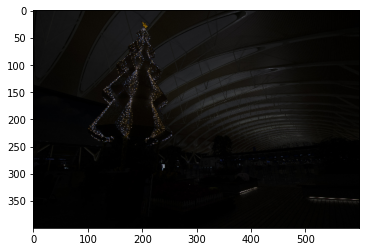

In [66]:
test_image_input = image_loader.load_image('/home/student/Documents/alena/thesis/enlighte-gan-dataset/train/dark/2_1_2.png')
plt.imshow(test_image_input)

test_image_input = image_tf.get_transforms(True, 320)(test_image_input)

gray = attention_map(test_image_input)

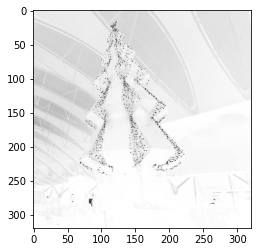

In [35]:
plt.imshow(gray.permute(1, 2, 0),cmap='gray')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


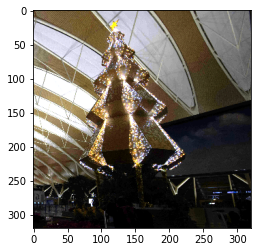

In [65]:
image = test_image_input.permute(1, 2, 0)
# plt.imshow(test_image_input.permute(1, 2, 0),cmap='gray')
plt.imshow((2 + image) ** 3.0 - 1) 

In [37]:
prediction = model._netG.forward(test_image_input[None, :, :, :].cuda(), gray[None, :, :, :].cuda())

In [56]:
prediction.detach().cpu().shape

3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


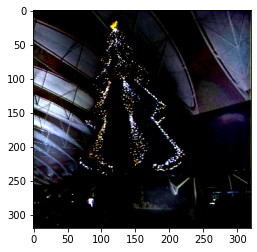

In [57]:
plt.imshow(prediction.detach().cpu()[0, :, :, :].permute(1, 2, 0))